# MUSHROOM CLASSIFIER

# Downloading Data

Download mushroom classification dataset from Kaggle.

In [4]:
import kagglehub
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
# Download dataset and print the returned path
path = kagglehub.dataset_download("maysee/mushrooms-classification-common-genuss-images")
print("Dataset downloaded to:", path)

Dataset downloaded to: /Users/marleeyork/.cache/kagglehub/datasets/maysee/mushrooms-classification-common-genuss-images/versions/1


CHecking file directory and data.

In [6]:
# Print the file directory
print("Path to dataset files:",path)

# List the downloaded files
print("Files in dataset directory:", os.listdir(path))

Path to dataset files: /Users/marleeyork/.cache/kagglehub/datasets/maysee/mushrooms-classification-common-genuss-images/versions/1
Files in dataset directory: ['Mushrooms']


# Data Preprocessing

## Skipping over truncated images.

In [9]:
from PIL import Image
import os

def safe_image_open(image_path):
    try:
        img = Image.open(image_path)
        img.verify() 
        img = Image.open(image_path) 
        img.load()
        return img.convert("RGB")
    except (OSError, IError):
        print(f"Skipping corrupted image: {image_path}")
        return None


## Resizing images to 224x224 and normalizing RGB values.

In [10]:
# Define the dataset path (use the printed `path` from kagglehub)
dataset_path = "/Users/marleeyork/deep_learning/midterm/C:/Users/marleeyork/deep_learning/midterm/Mushrooms/Mushrooms"

# Define image transformations (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

# Load dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Print class labels (folder names)
print(f"Classes: {dataset.classes}")

Classes: ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']


Create a function to print an image and explore some from the dataset.

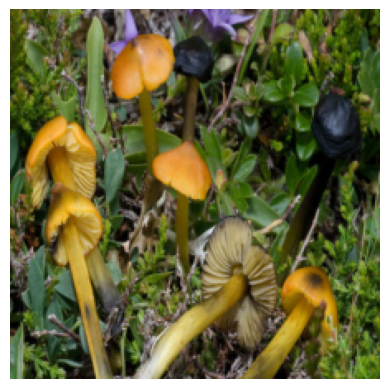

Classification: Hygrocybe


In [24]:
def print_an_image(data,idx=None):

    # if indice is None, randomly generate one
    if idx is None:
        idx = torch.randperm(len(dataset))[1]

    # Pull the image and class
    image, label = data[idx]
    classification = dataset.classes[label]

    # Convert from tensor to NumPy for plotting
    grid = image.numpy().transpose((1,2,0))

    # Unnormalize based on .5 mean and sd set earlier
    grid = grid*.5 + .5

    # Plot!
    plt.imshow(grid)
    plt.axis('off')
    plt.show()
    print(f"Classification: {classification}")

print_an_image(dataset)

Checking how many of each class there are.

In [7]:
class_count = [0]*9
for x in range(len(dataset)):
    idx = dataset[x][1]
    class_count[idx] = class_count[idx]+1
print(class_count)

[353, 750, 1073, 836, 364, 316, 1563, 1148, 311]


Set my random seeds for the remaining analysis.

In [12]:
seed = 456
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
generator = torch.Generator().manual_seed(seed)

Identifying training and test sets.

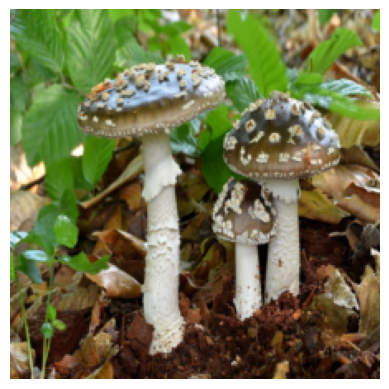

Classification: Amanita


In [13]:
# Determine number of training and testing images.
data_len = len(dataset)
train_len = int(data_len * .9)
test_len = data_len - train_len

# Randomly permute dataset indices and select those for training and testing.
rand_idx = torch.randperm(len(dataset))
train_idx = rand_idx[0:train_len]
test_idx = rand_idx[train_len:]

# Assign train and test sets based on their selected indices.
train_dataset, test_dataset = random_split(dataset, [train_len, test_len])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Printing an image from each data
print_an_image(train_dataset)


# Model 1: A simple CNN

Building a simple CNN with 2 convolutional layers and 2 artificial layers.

In [14]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Defining convolutional layers (reduced to 2)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # Define pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Define dropout, flattening, and activation function
        self.drop = nn.Dropout(p=.5)  
        self.flatten = nn.Flatten()
        self.activateHidden = nn.LeakyReLU(.1, inplace=True)
        self.activateTerminal = nn.Softmax(dim=1)

        self.fc_input_size = 56 * 56 * 64
        
        # Defining linear layers 
        self.linear1 = nn.Linear(in_features=self.fc_input_size, out_features=512)
        self.linear2 = nn.Linear(in_features=512, out_features=10)
        
    def forward(self, x):
        # First convolutional layer
        x = self.conv1(x)
        x = self.activateHidden(x)
        x = self.pool(x)
        
        # Second convolutional layer
        x = self.conv2(x)
        x = self.activateHidden(x)
        x = self.pool(x)
        
        # Flatten the output for the fully connected layers
        x = self.flatten(x)
        
        # First fully connected layer
        x = self.linear1(x)
        x = self.activateHidden(x)
        x = self.drop(x)
        
        # Second fully connected layer
        x = self.linear2(x)
        x = self.activateTerminal(x)
        
        return x
    
    def pred(self, x):
        output = self.forward(x)
        predicted_class = torch.argmax(output, dim=1)
        return predicted_class

Save the model.

In [18]:
torch.save(model.state_dict(), "model_simple.pth")
torch.save(losses_simple,"losses_simple.pth")
torch.save(train_val_simple,"train_val_simple.pth")

Set criterion as cross entropy and optimizer as stochastic gradient descent.

In [15]:
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Train the model.

In [16]:
losses_simple = []
train_val_simple = []

In [17]:
epochs = 60

for epoch in range(1,epochs):
    correct = 0  
    total = 0  
    epoch_loss = 0 
    batch_count = 0
    
    for images, labels in train_loader:  
        output = model(images)  
        
        loss = criterion(output, labels)  
        epoch_loss += loss.item() 
        batch_count += 1
        
        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step() 
        
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate metrics for the entire epoch
    avg_epoch_loss = epoch_loss / batch_count
    losses_simple.append(avg_epoch_loss)
    
    train_accuracy = 100 * correct / total
    train_val_simple.append(train_accuracy)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_epoch_loss:.4f}, Train accuracy: {train_accuracy}")

Epoch 2/60, Loss: 2.2224, Train accuracy: 23.369745117510757
Epoch 3/60, Loss: 2.1794, Train accuracy: 26.895067858325056
Epoch 4/60, Loss: 2.1428, Train accuracy: 31.032770605759683
Epoch 5/60, Loss: 2.1170, Train accuracy: 34.0946706388613
Epoch 6/60, Loss: 2.1023, Train accuracy: 35.60079443892751
Epoch 7/60, Loss: 2.0924, Train accuracy: 36.74280039721946
Epoch 8/60, Loss: 2.0822, Train accuracy: 37.603442568685864
Epoch 9/60, Loss: 2.0735, Train accuracy: 38.44753392916253
Epoch 10/60, Loss: 2.0681, Train accuracy: 39.192320423700764
Epoch 11/60, Loss: 2.0481, Train accuracy: 41.112214498510426
Epoch 12/60, Loss: 2.0350, Train accuracy: 42.65143992055611
Epoch 13/60, Loss: 2.0198, Train accuracy: 44.38927507447865
Epoch 14/60, Loss: 2.0022, Train accuracy: 46.11055941741145
Epoch 15/60, Loss: 1.9819, Train accuracy: 48.41112214498511
Epoch 16/60, Loss: 1.9566, Train accuracy: 50.74478649453823
Epoch 17/60, Loss: 1.9403, Train accuracy: 52.64812975835816
Epoch 18/60, Loss: 1.9191, 

Plot the training accuracy over epochs.

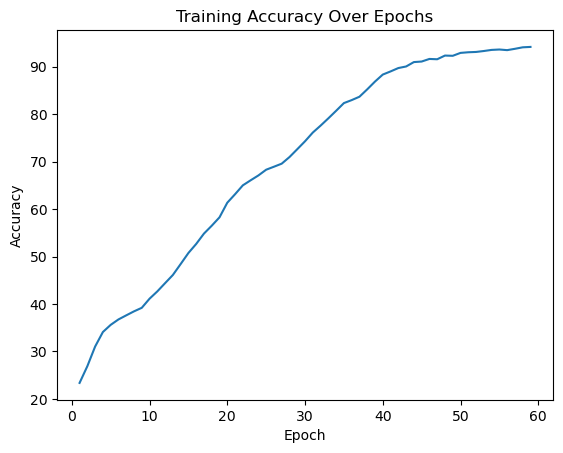

In [20]:
plt.plot(list(range(1,60)),train_val_simple)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Over Epochs")
plt.show()

Calculate the testing accuracy.

In [21]:
correct = 0
total = 0

for images, labels in test_loader:
    output = model(images)
    m, predicted = torch.max(output, 1)

    for i in range(1,len(predicted)):
        total += 1
        if predicted[i]==labels[i]:
            correct += 1

test_accuracy = 100 * correct / total
print(f"Test accuracy: {test_accuracy}")

Test accuracy: 42.05748865355522


# Model 2: Adding more complexity with increased layers

In [39]:
class CNN(nn.Module):
    def __init__(self):
        
        super().__init__()
        
        # Defining convolutional and pooling layers
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1)
        
        # Define pooling
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
        # Define dropout, flattening, and activation function
        self.drop = nn.Dropout(p=.5)
        self.flatten = nn.Flatten()
        self.activateHidden = nn.LeakyReLU(.1,inplace=True)
        self.activateTerminal = nn.Softmax(dim=1)
        
        # Defining linear layers
        self.linear1 = nn.Linear(in_features=50176, out_features=512)
        self.linear2 = nn.Linear(in_features=512, out_features=128)
        self.linear3 = nn.Linear(in_features=128, out_features=64)
        self.linear4 = nn.Linear(in_features=64, out_features=10)


    def forward(self, x):
        x = self.conv1(x)
        x = self.activateHidden(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.activateHidden(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.activateHidden(x)
        x = self.pool(x)

        x = self.conv4(x)
        x = self.activateHidden(x)
        x = self.pool(x)

        x = self.flatten(x)

        x = self.linear1(x)
        x = self.activateHidden(x)
        x = self.drop(x)

        x = self.linear2(x)
        x = self.activateHidden(x)
        x = self.drop(x)
        
        x = self.linear3(x)
        x = self.activateHidden(x)
        x = self.linear4(x)

        return x


    def pred(self,x):
        output = self.forward(x)
        probabilities = nn.Softmax(dim=1)(output) 
        predicted_class = torch.argmax(probabilities, dim=1)
        
        return predicted_class

Defining a model, cross entropy loss criterion, and stochastic gradient descent optimizer.

In [40]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Train the model using backpropagation.

In [42]:
losses = [] 
train_val = [] 
epochs = 75

for epoch in range(epochs):
    correct = 0  # Reset for each epoch
    total = 0  # Reset for each epoch
    epoch_loss = 0  # Track the total loss for the epoch
    batch_count = 0  # Count batches in the epoch
    
    for images, labels in train_loader:  
        output = model(images)  
        
        loss = criterion(output, labels)  
        epoch_loss += loss.item()  # Accumulate loss for averaging later
        batch_count += 1
        
        #print(f"Before Backprop - Loss: {loss.item():.4f}")
        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step() 
        
        # calculate training accuracy
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate metrics for the entire epoch
    avg_epoch_loss = epoch_loss / batch_count
    losses.append(avg_epoch_loss)
    
    train_accuracy = 100 * correct / total
    train_val.append(train_accuracy)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_epoch_loss:.4f}, Train accuracy: {train_accuracy}")

Epoch 1/75, Loss: 2.0461, Train accuracy: 22.955974842767297
Epoch 2/75, Loss: 2.0202, Train accuracy: 23.915921880172128
Epoch 3/75, Loss: 1.9782, Train accuracy: 26.99437272426349
Epoch 4/75, Loss: 1.9416, Train accuracy: 28.43429328037074
Epoch 5/75, Loss: 1.9096, Train accuracy: 29.344587884806355
Epoch 6/75, Loss: 1.8862, Train accuracy: 30.71830519695465
Epoch 7/75, Loss: 1.8545, Train accuracy: 32.704402515723274
Epoch 8/75, Loss: 1.8195, Train accuracy: 34.49189010261503
Epoch 9/75, Loss: 1.7714, Train accuracy: 36.544190665342605
Epoch 10/75, Loss: 1.7151, Train accuracy: 37.68619662363456
Epoch 11/75, Loss: 1.6652, Train accuracy: 41.062562065541215
Epoch 12/75, Loss: 1.6119, Train accuracy: 43.18106587222774
Epoch 13/75, Loss: 1.5262, Train accuracy: 45.77954319761668
Epoch 14/75, Loss: 1.4467, Train accuracy: 49.10625620655412
Epoch 15/75, Loss: 1.3371, Train accuracy: 52.962595167163194
Epoch 16/75, Loss: 1.2324, Train accuracy: 57.10029791459782
Epoch 17/75, Loss: 1.0944,

Save the model.

In [ ]:
torch.save(model.state_dict(), "model1.pth")
torch.save(losses,"losses1.pth")
torch.save(train_val,"train_val1.pth")

Plotting the training error.

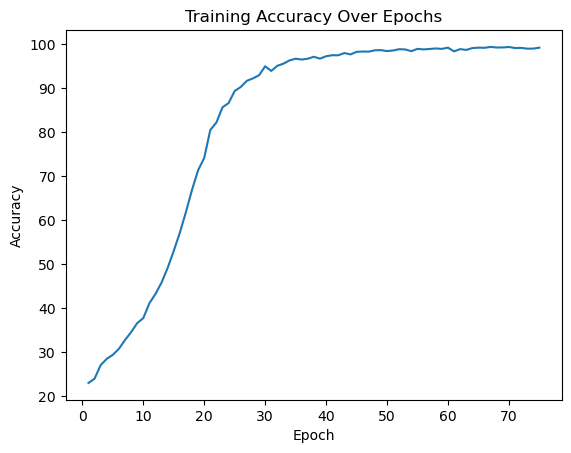

In [55]:
plt.plot(list(range(1,76)),train_val)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Over Epochs")
plt.show()

Calculating testing accuracy.

In [43]:
correct = 0
total = 0

for images, labels in test_loader:
    output = model(images)
    m, predicted = torch.max(output, 1)

    for i in range(1,len(predicted)):
        total += 1
        if predicted[i]==labels[i]:
            correct += 1

test_accuracy = 100 * correct / total
print(f"Test accuracy: {test_accuracy}")

Test Accuracy: 44.20%


# Model 3: Increasing dropout, removing convolutional layer, and increase pooling/stride

Given the distance between the testing accuracy and training accuracy, there is a deal of overfitting occurring. In response, the next model will have a greater dropout, a layer removed, and be trained on fewer epochs.

In [10]:
class CNN2(nn.Module):
    def __init__(self):
        
        super().__init__()
        
        # Defining convolutional and pooling layers
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
        
        # Define pooling
        self.pool = nn.MaxPool2d(kernel_size=4,stride=4)
        
        # Define dropout, flattening, and activation function
        self.drop = nn.Dropout(p=.7)
        self.flatten = nn.Flatten()
        self.activateHidden = nn.LeakyReLU(.1,inplace=True)
        self.activateTerminal = nn.Softmax(dim=1)
        
        # Defining linear layers
        self.linear1 = nn.Linear(in_features=1152, out_features=512)
        self.linear2 = nn.Linear(in_features=512, out_features=128)
        self.linear3 = nn.Linear(in_features=128, out_features=64)
        self.linear4 = nn.Linear(in_features=64, out_features=10)


    def forward(self, x):
        x = self.conv1(x)
        x = self.activateHidden(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.activateHidden(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.activateHidden(x)
        x = self.pool(x)

        x = self.flatten(x)

        x = self.linear1(x)
        x = self.activateHidden(x)
        x = self.drop(x)

        x = self.linear2(x)
        x = self.activateHidden(x)
        x = self.drop(x)
        
        x = self.linear3(x)
        x = self.activateHidden(x)
        x = self.linear4(x)  

        return x

    def pred(self,x):
        output = self.forward(x)
        probabilities = nn.Softmax(dim=1)(output) 
        predicted_class = torch.argmax(probabilities, dim=1)
        
        return predicted_class

In [11]:
model = CNN2()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [12]:
losses2 = []
train_val2 = []

In [13]:
epochs = 80

for epoch in range(1,epochs):
    correct = 0  
    total = 0  
    epoch_loss = 0 
    batch_count = 0
    
    for images, labels in train_loader:  
        output = model(images)  
        
        loss = criterion(output, labels)  
        epoch_loss += loss.item() 
        batch_count += 1
        
        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step() 
        
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate metrics for the entire epoch
    avg_epoch_loss = epoch_loss / batch_count
    losses2.append(avg_epoch_loss)
    
    train_accuracy = 100 * correct / total
    train_val2.append(train_accuracy)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_epoch_loss:.4f}, Train accuracy: {train_accuracy}")

Epoch 2/80, Loss: 2.1468, Train accuracy: 21.56570671962926
Epoch 3/80, Loss: 2.0602, Train accuracy: 23.00562727573651
Epoch 4/80, Loss: 2.0550, Train accuracy: 23.071830519695464
Epoch 5/80, Loss: 2.0470, Train accuracy: 23.00562727573651
Epoch 6/80, Loss: 2.0333, Train accuracy: 22.80701754385965
Epoch 7/80, Loss: 2.0025, Train accuracy: 25.42204568023833
Epoch 8/80, Loss: 1.9729, Train accuracy: 28.566699768288647
Epoch 9/80, Loss: 1.9566, Train accuracy: 27.904667328699105
Epoch 10/80, Loss: 1.9303, Train accuracy: 29.228732207878185
Epoch 11/80, Loss: 1.9245, Train accuracy: 30.536246276067526
Epoch 12/80, Loss: 1.9024, Train accuracy: 30.205230056272757
Epoch 13/80, Loss: 1.8793, Train accuracy: 31.876861966236344
Epoch 14/80, Loss: 1.8629, Train accuracy: 32.27408142999007
Epoch 15/80, Loss: 1.8327, Train accuracy: 32.704402515723274
Epoch 16/80, Loss: 1.7891, Train accuracy: 35.13737173121483
Epoch 17/80, Loss: 1.7661, Train accuracy: 36.41178417742469
Epoch 18/80, Loss: 1.714

In [37]:
torch.save(model.state_dict(), "model2.pth")
torch.save(losses2,"losses2.pth")
torch.save(train_val2,"train_val2.pth")

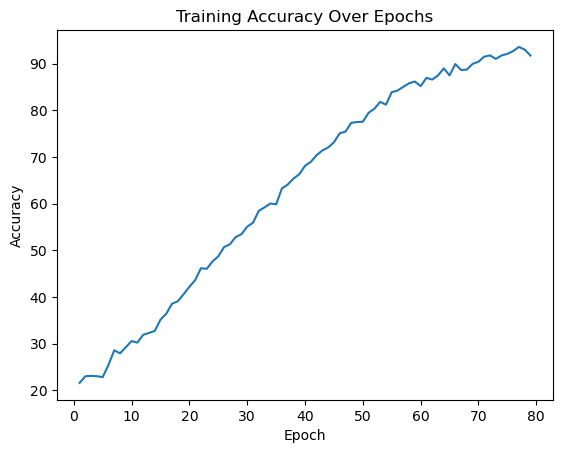

In [18]:
plt.plot(list(range(1,80)),train_val2)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Over Epochs")
plt.show()

In [32]:
correct = 0
total = 0

for images, labels in test_loader:
    output = model(images)
    m, predicted = torch.max(output, 1)

    for i in range(1,len(predicted)):
        total += 1
        if predicted[i]==labels[i]:
            correct += 1

test_accuracy = 100 * correct / total
print(f"Test accuracy: {test_accuracy}")

Test accuracy: 55.6732223903177
